<a href="https://www.kaggle.com/mishki/tutorial-time-series-exploration-crypto-price?scriptVersionId=86317462" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Quick intro**

I wanted to see a notebook / tutorial that would take me through the **basics of working with time series**.  

Most notebooks I saw were either not very rigorous or they took me straight into price prediction using some methods, which is not what I needed right away.  

So I wrote my own introductory notebook. I acquired most of the information I used here through reading <a href='https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/'>Introduction to Time Series Forecasting With Python</a> by Jason Brownlee (took a few days to read an implement).   

What this notebook is:  
- a good starting point for understanding time series data and how it differs from problems with other type of tabular data 
- a cookbook we can use for exploration when starting to work with a new dataset

What this notebook is not:
- it is not about prediction. It stops at exploration and understanding the data.
- it's not meant for advanced practitioners of asset price prediction - unless you want to revisit some concepts.  

### Contents

[1. Quick overview](#1.-Quick-overview)  
[2. Dataset description](#2.-Dataset-description)  
[3. Basic trading data visualization](#3.-Basic-trading-data-visualization)  
[4. Preprocessing](#4.-Preprocessing)  
[5. Feature engineering](#5.-Feature-engineering)  
[6. Typical time series visualizations](#6.-Typical-time-series-visualizations)  
[7. Power transforms](#7.-Power-transforms)  
[8. Temporal structure of time series data](#8.-Temporal-structure-of-time-series-data)  
[9. Model evaluation](#9.-Model-evaluation)

# 1. Quick overview

This dataset was made available on Kaggle as part of the <a href='https://www.kaggle.com/c/g-research-crypto-forecasting/overview'>G-Research Crypto forecasting competition</a>. The challenge proposed by G-Research was to predict price returns across a bundle of major cryptocurrencies for which we have approximately 3 years of historical price data.  

# 2. Dataset description

In [1]:
import pandas as pd
import numpy as np
import os 
import time

import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
data_folder = "../input/g-research-crypto-forecasting/"
!ls $data_folder

asset_details.csv	       example_test.csv  supplemental_train.csv
example_sample_submission.csv  gresearch_crypto  train.csv


Available files (provided by the organizers of the competition):
- **train.csv**
- **asset_details.csv**
- example_sample_submission.csv
- example_test.csv
- supplemental_train.csv

Only the first two seem interesting for now.

In [3]:
start = time.time()

crypto_df = pd.read_csv(os.path.join(data_folder, 'train.csv'))

end = time.time()
print(end - start) # just ouf curiosity, see how long it takes to read such a large csv file

65.6975417137146


In [4]:
crypto_df.shape

(24236806, 10)

There are approximately 24 million observations in our time series.

In [5]:
crypto_df.head(2)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.58,2399.50,2357.14,2374.59,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.53,8.53,8.53,8.53,78.380000,8.530000,-0.014399


**Data features**  

- **timestamp** - Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
- **Asset_ID** - uniquely identifies the traded coin
- **Count** - number of trades executed within the respective minute
- **Open, High, Low, Close** - the usual price details for a given unit of time. 
- **Volume** - amount of units of this coin traded in the particular minute
- **VWAP** - The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
- **Target** - Residual log-returns for the asset over a 15 minute horizon <- we know this from the competition's official description.

In [6]:
start = crypto_df.iloc[0].timestamp.astype('datetime64[s]')
end = crypto_df.iloc[-1].timestamp.astype('datetime64[s]')

print(f'Data from {start} until {end}')

Data from 2018-01-01T00:01:00 until 2021-09-21T00:00:00


We have approximately 3 years worth of data. This informs the type of time windows we can look at.  

For example, if we zoom out at an yearly resolution, we can only compare 2018, 2019 and 2020 (2021 is incomplete).

### Assets 

In the list of transactions, assets are referred to by Asset_ID. Let's look into **asset_details.csv** to see what these 'assets' are.

In [7]:
asset_details_df = pd.read_csv(os.path.join(data_folder, 'asset_details.csv'))

In [8]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


An interesting selection of 14 crypto coins. I say interesting because, as a crypto investor myself, I wonder what IOTA and Dogecoin are doing in there.

# 3. Basic trading data visualization

Get a subset of our data (the last 60 entries for example) and restrict the analysis to one asset (which makes it a univariate analysis). 

In [9]:
btc_mini_df = crypto_df[crypto_df.Asset_ID == 1].iloc[-60:]

In [10]:
btc_mini_df.head(4)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
24235969,1632178860,1,1952.0,43353.12000,43376.00,43283.10,43344.558571,65.051627,43329.733310,-0.000184
24235983,1632178920,1,4369.0,43365.74875,43546.61,43335.64,43484.613750,145.414597,43446.758145,0.000255
24235997,1632178980,1,4638.0,43477.08750,43640.00,43441.56,43580.823750,180.392877,43544.364733,0.001151
24236011,1632179040,1,3211.0,43588.10250,43627.00,43428.80,43470.795000,149.275363,43535.659814,0.002428


Let's transform the timestamp into the index of our dataframe. This will facilitate some operations down the road.

In [11]:
btc_mini_df = btc_mini_df.set_index("timestamp")

We can use the **candlestick** function from the **graph_objects package** of plotly to visualize trading data as the common candlestick plot.

In [12]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini_df.index, 
                                     open=btc_mini_df['Open'], 
                                     high=btc_mini_df['High'], 
                                     low=btc_mini_df['Low'], 
                                     close=btc_mini_df['Close'])])
fig.show()

Candlestick plots look nice and fancy, but later we'll go beyond this into exploring trends, cycles and seasonality of the dataset.  

For now, it's just a way to get a quick look at our data, so we have a mental model of what we're dealing with.

# 4. Preprocessing  

Detecting features for which we have missing values is easy to do. We just look for null values per column.   

In [13]:
btc_df = crypto_df[crypto_df.Asset_ID == 1].set_index('timestamp')

btc_df.info(show_counts =True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956282 entries, 1514764860 to 1632182400
Data columns (total 9 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Asset_ID  1956282 non-null  int64  
 1   Count     1956282 non-null  float64
 2   Open      1956282 non-null  float64
 3   High      1956282 non-null  float64
 4   Low       1956282 non-null  float64
 5   Close     1956282 non-null  float64
 6   Volume    1956282 non-null  float64
 7   VWAP      1956282 non-null  float64
 8   Target    1955978 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 149.3 MB


Or, more clearly:

In [14]:
btc_df.isna().sum()

Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target      304
dtype: int64

Not a lot of data is missing. We can drop those rows, impute the values etc. I'm not going to use Target, so I won't go into this right now. 

The more covert missing data is when we don't have any information at all for a particular minute. Which means that **whole rows may be missing** from our dataset.  

We should have one row per minute per asset. Since we extracted the data for a single asset, we expect consecutive rows to have a difference of 60 seconds between their index values.  

First step is to look at the **time lag between consecutive entries** in our dataset.

In [15]:
# we start with 1 instead of 0 since there's nothing to compare the first entry to
(btc_df.index[1:]-btc_df.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

We see that we have 78 instances where two consecutive entries are 120 seconds apart, instead of 60 sec, and so on. 

Because the gaps in data are so small, we can use a simple imputation method: fill in the missing data with the value from the most recent available minute.  

This is what the *method = 'pad'* parameter of the *reinde* function below does.    

In [16]:
btc_df = btc_df.reindex(range(btc_df.index[0],btc_df.index[-1]+60,60), method='pad')

Check the output

In [17]:
(btc_df.index[1:]-btc_df.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

Great, no more time gaps in our dataset !  

We don't need the index as a timestamp anymore. For future analysis it will be easier to have it as a date.

In [18]:
btc_df['datetime'] = btc_df.apply(lambda r: np.float64(r.name).astype('datetime64[s]'), axis=1)

btc_df.set_index('datetime', inplace=True);

btc_df.head(3)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
datetime,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309


# 5. Feature engineering

According to the usual taxonomy of Machine Learning, we have supervised, unsupervised and reinforcement learning problems. I'm looking to apply supervised learning methods for this data.  

The data does not look like the typical supervised learning dataset. In supervised learning data, for each row we expect to see several features and a label / value that we're trying to predict based on those features. 

Let's have a look again at our dataset below. Definitely not what we need, yet.

In [19]:
btc_df.head(3)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
datetime,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309


#### Rephrasing the dataset into a supervised learning dataset. 

In supervised learning datasets we have entries with a set of features (our **x**) and a label / value for our output variable which we want to predict (our **y**).  

In the case of time series, our output **y** is the price at time t. But what are the inputs for a possible prediction model ?   

To phrase it differently, for each entry in our dataset we need to have a set of feaures and a label (used for training and then outputted as a prediction of our model).  

This means we need to convert our original data:

| time | value |
| --- | --- |
| 1514764860 | 13850.176 | 
| 1514764920 | 13828.102 |
| 1514764980 | 13801.314 |
| ... | ... |

into something of this form:

| x | y |
| --- | --- |
| x1 | y1 |
| x2 | y2 |
| x3 | y3 |

#### Types of features (x) we can create from time series data:  
- **date time** features 
- **lag** features  
- **window** features   

### 5.1 Date time features

Again, our data looks like this:  

| timestamp | value |
| --- | --- |
| 1514764860 | 13850.176 | 
| 1514764920 | 13828.102 |
| 1514764980 | 13801.314 |
| ... | ... |

We can transform the timestamp into day, hour, min, this way creating three new features.  

What types of questions we can answer with this approach ? We can imagine a problem where we're trying to predict the price for a specific time on a specific day.  

This makes more sense if our data was temperatures throughout the day, where we know there are daily cycles, yearly cycles etc, rather than stocks, but we're just using this for illustration purposes for now.  

In [20]:
btc_mini_df = btc_df[-7201:].copy(deep=True)  # the 7201 comes from me cheating and looking ahead into the results, trying to get full days of data

In [21]:
btc_mini_df.head(3)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
datetime,,,,,,,,,
2021-09-16 00:00:00,1,2466.0,48142.545443,48188.12,48086.22,48101.315714,100.182817,48132.845372,0.001079
2021-09-16 00:01:00,1,1757.0,48101.928395,48164.10,48080.00,48135.600000,64.948787,48112.135086,0.001212
2021-09-16 00:02:00,1,2331.0,48135.697143,48211.23,48069.62,48186.595714,101.655798,48125.096256,0.001464


In [22]:
btc_mini_df['time'] = btc_mini_df.apply(lambda r:r.name, axis=1) # I need to move timestamp back into a column

# and parse it into year, month, day and hour
btc_mini_df['year'] = [btc_mini_df.iloc[i].time.year for i in range(len(btc_mini_df))]  
btc_mini_df['month'] = [btc_mini_df.iloc[i].time.month for i in range(len(btc_mini_df))]
btc_mini_df['day'] = [btc_mini_df.iloc[i].time.day for i in range(len(btc_mini_df))]
btc_mini_df['hour'] = [btc_mini_df.iloc[i].time.hour for i in range(len(btc_mini_df))]

In [23]:
btc_mini_df.head(3)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,time,year,month,day,hour
datetime,,,,,,,,,,,,,,
2021-09-16 00:00:00,1,2466.0,48142.545443,48188.12,48086.22,48101.315714,100.182817,48132.845372,0.001079,2021-09-16 00:00:00,2021,9,16,0
2021-09-16 00:01:00,1,1757.0,48101.928395,48164.10,48080.00,48135.600000,64.948787,48112.135086,0.001212,2021-09-16 00:01:00,2021,9,16,0
2021-09-16 00:02:00,1,2331.0,48135.697143,48211.23,48069.62,48186.595714,101.655798,48125.096256,0.001464,2021-09-16 00:02:00,2021,9,16,0


In [24]:
# average data per hour 
tmp = btc_mini_df.groupby(['year', 'month', 'day', 'hour']).mean()

# restore the multilevel index created by groupby into the year, month, day, hour columns that we created earlier
tmp.reset_index(inplace=True)

In [25]:
cols = ['year', 'month', 'day', 'hour', 'Close']

tmp[cols].head(5)

,year,month,day,hour,Close
0,2021,9,16,0,48011.855849
1,2021,9,16,1,47989.773176
2,2021,9,16,2,47961.590146
3,2021,9,16,3,47622.839055
4,2021,9,16,4,48175.404142


And that would be our training data for a supervised learning model.

Trying to predict coin prices based on day and hour will likely be a poor model.  

But we can enrich these features with additional ones. Here are a few candidates:
- Weekend or not.
- Season of the year.
- Business quarter of the year.  
etc  

I'm not convinced this would help much, so I'll explore further ways to build features.

### 5.2 Lag features  

This is the typical way in which time series data is tranformed into a supervised learning problem.  

The idea is to predict the value at the current timestamp based on the value from the previous timestamp(s).   

**Nomenclature:**  
- because we are predicting a single variable, this is called **univariate**  
- the number of previous time steps we use in our prediction is called the **width of the time window** or **the lag**
- if we predict only one future time step we are doing **one-step forecast**. We can also perform **multi-step forecast** and predict multiple next steps at once 
- this method is also called **sliding window**, with a window width of 1 in our case below.

Initial dataset:  

| time | value |  
| --- | ---|   
| t1 | v1  
| t2 | v2  
| t3 | v3

becomes:    

| x | y | 
| --- | --- |     
| ? | v1      
| v1 | v2  
| v2 | v3  

The actual value for timestamp is gone from our data. We don't care about it, as long as we preserve the order. We only care about the actual value at the previous point in time.

We use pandas' dataframe.shift() function, which shifts values vertically or horizontally, fills in with NaN values and leaves the index as it is.

In [26]:
tmp = btc_mini_df['Close'] # extract only the Close price

lag_df = pd.concat([tmp.shift(1, axis = 0), tmp], axis=1) # downward shift by 1 step 

# the original price series becomes the time t value, 
# while the downward shifted series is time t+1
lag_df.columns = ['Close(t)', 'Close(t+1)'] 

lag_df.head()

,Close(t),Close(t+1)
datetime,,
2021-09-16 00:00:00,NaN,48101.315714
2021-09-16 00:01:00,48101.315714,48135.600000
2021-09-16 00:02:00,48135.600000,48186.595714
2021-09-16 00:03:00,48186.595714,48163.827500
2021-09-16 00:04:00,48163.827500,48106.416629


The same transformation as above, but this time we include the 3 previous values, for each future time t+1:

In [27]:
lag_df = pd.concat([tmp.shift(3), tmp.shift(2), tmp.shift(1), tmp], axis=1)

lag_df.columns = ['Close(t-2)', 'Close(t-1)', 'Close(t)', 'Close(t+1)'] # rename columns for easier read

lag_df.head()

,Close(t-2),Close(t-1),Close(t),Close(t+1)
datetime,,,,
2021-09-16 00:00:00,NaN,NaN,NaN,48101.315714
2021-09-16 00:01:00,NaN,NaN,48101.315714,48135.600000
2021-09-16 00:02:00,NaN,48101.315714,48135.600000,48186.595714
2021-09-16 00:03:00,48101.315714,48135.600000,48186.595714,48163.827500
2021-09-16 00:04:00,48135.600000,48186.595714,48163.827500,48106.416629


Finally, the lag does not have to be linear: we don't necessarily have to use the previous k values. We can include in the lag window values from the same day last week or the same hour the day before etc. 

### 5.3 Window features  

We saw how we can add a window of a certain width as features to be used by our model to forecast the value at future time t+1.  

Besides using the raw values from the time window (i.e. Close(t-1), Close(t), etc), we can also compute *summary statistics* of these values and use them as features for prediction.  

The most common aggregate value is the mean of the lag window (also called **moving average** or **rolling mean**).

| time | value |  
| --- | --- |  
| t1 | v1  
| t2 | v2  
| t3 | v3  
| t4 | v4

**shifted**  

| time | value | 
| --- | --- |  
| t1 | ?  
| t2 | v1  
| t3 | v2  
| t4 | v3

shifted, applied **rolling mean** (aka moving average ) with a window size of 2  

| time | value | 
| --- | --- |  
| t1 | ? |  
| t2 | ? | 
| t3 | (v1+v2) / 2 | 
| t4 | (v2+v3) / 2 |

Final dataset

| time | mean | Close(t+1) |  
| --- | --- | --- |   
t1&emsp;$\;$|  ?  |  v1  |  
t2&emsp;$\;$|  ?  |  v2  |  
t3&emsp;$\;$|  (v1+v2) / 2  |  v3  |  
t4&emsp;$\;$|  (v2+v3) / 2  |  v4  |  

The moving average can be used as a naive prediction model: predict for next day the average of the last *w* days (where *w* is the width of the moving average window). But before doing this, the theory says we are supposed to have *stationary* data (having no obvious upward or downward trend and no seasonality), so we'll need some further preprocessing down the road. 

In [28]:
tmp = btc_mini_df['Close'] # extract only the Close price

lag_df = tmp.shift(1) # downward shift by 1

window = lag_df.rolling(window=2) # rolling window size of 2
means = window.mean() # compute the means for the rolling windows

new_df = pd.concat([means, tmp], axis=1) # concatenate the two series vertically

new_df.columns = ['mean(t-1,t)', 't+1'] # rename columns for easier reading

new_df.head()

,"mean(t-1,t)",t+1
datetime,,
2021-09-16 00:00:00,NaN,48101.315714
2021-09-16 00:01:00,NaN,48135.600000
2021-09-16 00:02:00,48118.457857,48186.595714
2021-09-16 00:03:00,48161.097857,48163.827500
2021-09-16 00:04:00,48175.211607,48106.416629


There are of course many summary statistics we can use besides the average for the previous time window.    

Also, the window does not have to have a fixed width. It can also be a forever expanding window.  

| time | value |
| --- | --- | 
| t1 | 1 | 
| t2 | 2 | 
| t3 | 3 | 
| t4 | 4 | 
| t4 | 5 |

**expanding** rolling window  

| # |values |
| --- | --- |
| 0 | 1 2 |
| 1 | 1 2 3 |
| 2 | 1 2 3 4 |
| 4 | 1 2 3 4 5 |

final engineered dataset having summay statistics (min, mean and max window values) computed for the **expanding** rolling window

| # | min | mean | max | t+1 |
| --- | --- | --- | --- | --- |
| 0 | 1 | 1 | 1 | 2 |
| 1 | 1 | 1.5 | 2 | 3 |
| 2 | 1 | 2 | 3 | 4 |
| 3 | 1 | 2.5 | 4 | 5 |

In [29]:
window = tmp.expanding()

dataframe = pd.concat([window.min(), window.mean(), window.max(), tmp.shift(-1)], axis=1)

dataframe.columns = ['min', 'mean', 'max', 't+1']

print(dataframe.head(5))

                              min          mean           max           t+1
datetime                                                                   
2021-09-16 00:00:00  48101.315714  48101.315714  48101.315714  48135.600000
2021-09-16 00:01:00  48101.315714  48118.457857  48135.600000  48186.595714
2021-09-16 00:02:00  48101.315714  48141.170476  48186.595714  48163.827500
2021-09-16 00:03:00  48101.315714  48146.834732  48186.595714  48106.416629
2021-09-16 00:04:00  48101.315714  48138.751112  48186.595714  48075.588750


In [30]:
# have a look at the initial dataset again, to verify that tha dataframe above is correct
tmp.head(3)

datetime
2021-09-16 00:00:00    48101.315714
2021-09-16 00:01:00    48135.600000
2021-09-16 00:02:00    48186.595714
Name: Close, dtype: float64

<a id='log_returns'></a>
#### Log returns feature engineering

A typical feature for assets price time series is the ratio between the current price and the price at the previous time point. This is usually computed as a log of the ratio in time series modelling, because that facilitates some apperations (additions, etc). In this case, they are called **log returns**.

To compute the log return, we can simply take the difference between the logarithm of two consecutive prices. 

In [31]:
# helper function to compute the log returns
def log_returns(series, periods = 1):
    return np.log(series).diff(periods = periods)

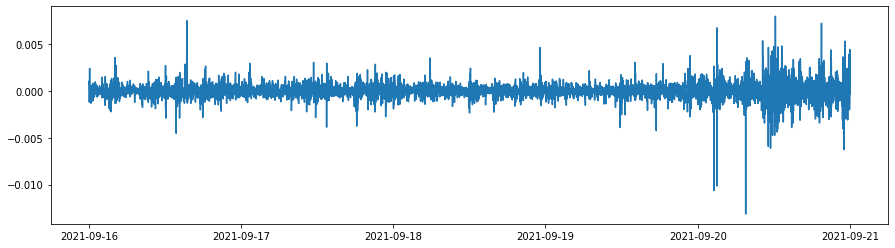

In [32]:
f = plt.figure(figsize = (15,4))

lret_btc = log_returns(btc_mini_df.Close,1)[1:]

plt.plot(lret_btc)

plt.show()

To sum up, the three methods above are a few basic and common ways (by the book) in which time series are rephrased into a dataset on which we can apply supervised machine learning methods.  

That's it for feature engineering for now. I'll move on to visualizing the data.

# 6. Typical time series visualizations  

There are 3 types of information to explore in a time series through visualization:

<strong>temporal structure:</strong>  
&emsp;- line plots  
&emsp;- lag plots  
&emsp;- autocorrelation plots  
<strong>the distribution of observations:</strong>  
&emsp;- histograms  
&emsp;- density plots  
<strong>the change in distribution over time intervals:</strong>  
&emsp;- box and whisker plots  
&emsp;- heatmap plots

### 6.1 Line plots

In [33]:
btc_df.head(3)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
datetime,,,,,,,,,
2018-01-01 00:01:00,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2018-01-01 00:02:00,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2018-01-01 00:03:00,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309


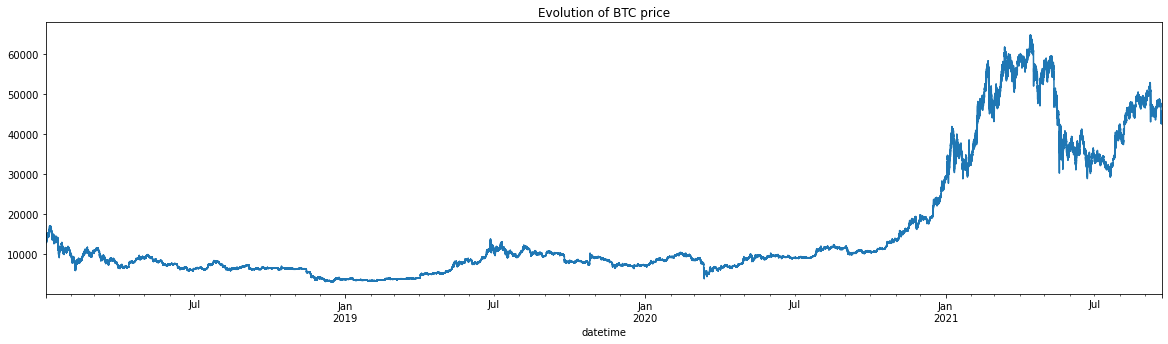

In [34]:
#btc_df.plot(x='datetime', y='Close', figsize=(8,5))
btc_df.Close.plot(figsize=(20,5))
plt.title('Evolution of BTC price')
plt.show()

The plot is a bit dense, since it contains all the data we had (almost 3 years worth of data, on a 1-minuted resolution).  

But it's apparent that we don't see a noticeable pattern (no apperent pattern that repeats itself year after year, for example).  

For time series, it can be better to look at and compare plots from the same interval, like day-to-day, year-to-year etc.

Let's assume we're naive about crypto prices and we want to investigate whether there is an daily seasonality, so we want to plot it in a more informative way. 

In [35]:
print(btc_mini_df.iloc[0].time)
print(btc_mini_df.iloc[-2].time)
print(btc_mini_df.iloc[-1].time)

2021-09-16 00:00:00
2021-09-20 23:59:00
2021-09-21 00:00:00


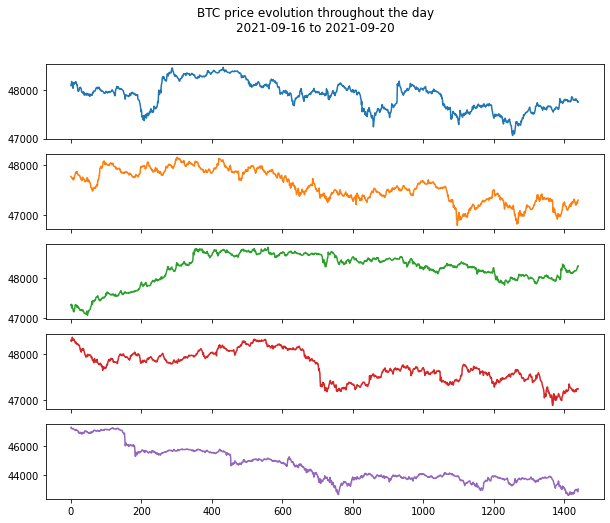

In [36]:
groups = btc_mini_df.groupby('day')

days = pd.DataFrame()

for name, group in groups:
    if name == 21: # skip the last day, which seems to be incomplete 
        continue
    days[name] = group.Close.values

days.plot(subplots=True, legend=False, figsize=(10,8), title='BTC price evolution throughout the day\n2021-09-16 to 2021-09-20');

If we have some domain knowledge, we can say that we're not surprised we don't see any correlation between consecutive days.

### 6.2 Histograms and density plots  

Some linear time series forecasting methods assume a well-behaved distribution of observations (like a normal distribution).  

Before doing statistical tests to formally assess the assumption of normality, we can easily visualize our data as a histogram.

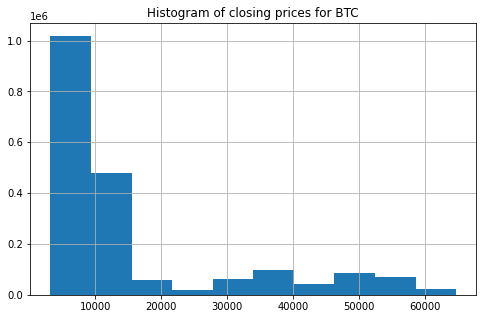

In [37]:
btc_df.Close.hist(figsize=(8,5))
plt.title('Histogram of closing prices for BTC')
plt.show()

Let's see it as a density plot too.


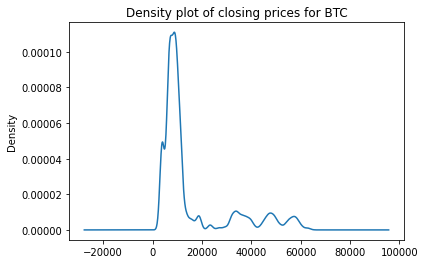

In [38]:
btc_df.Close.plot(kind='kde')
plt.title('Density plot of closing prices for BTC')
plt.show()

We see the same information from the line plot and no further insight.  


### 6.3 Box and whisker plots

We looked at the distribution of values across the whole timeframe (3 years worth of data).  

But it may be useful to examine the distribution in smaller time windows.  

Let's group our data by year and visualize it as box and whisker plots.

In [39]:
print(btc_df.iloc[0].name)
print(btc_df.iloc[-2].name)
print(btc_df.iloc[-1].name)

2018-01-01 00:01:00
2021-09-20 23:59:00
2021-09-21 00:00:00


In [40]:
btc_df.groupby(pd.Grouper(freq='A')).size()

datetime
2018-12-31    525599
2019-12-31    525600
2020-12-31    527040
2021-12-31    378721
Freq: A-DEC, dtype: int64

We don't have the same number of observations for each year. 2020 has one extra day, for example. 2018 is missing a single data point. And 2021 is quite incomplete. 
Just to proceed fast through this step, I'll use a quick dirty trick and join the data for each year while filling in missing values with NaN. It's not the best thing to do, but for the scope of this analysis it's good enough. 

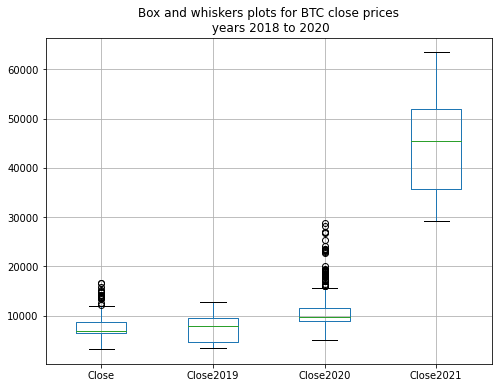

In [41]:
groups = btc_df.groupby(pd.Grouper(freq='A')) # group by year

years = pd.DataFrame([])

for name, group in groups: # iterate through the years
    tmp = group.groupby(pd.Grouper(freq='D')).Close.mean() # compute the daily mean
    tmp.index = tmp.index.strftime('%m-%d') # transform the index into 'mm-dd' only
    
    years = years.join(tmp, rsuffix=name.year, how = "outer") # join together yearly series (on the 'mm-dd' index) 
    
years.boxplot(figsize=(8,6))

plt.title('Box and whiskers plots for BTC close prices\n years 2018 to 2020');

[Short recap]   
A box plot is interpretted like this:

- The middle 50% of the data is contained in the block itself. The upper edge (hinge) of the box indicates the 75th percentile of the data set, and the lower hinge indicates the 25th percentile. 
- The horizontal line inside the box indicates the median value of the data.
- If the median line within the box is not equidistant from the hinges, then the data is skewed.
- The small horizontal ends of the vertical lines (the "whiskers") indicate the minimum and maximum data values, unless outliers are present in which case the whiskers extend to a maximum of 1.5 times the inter-quartile range (the hight of the box).
- The points outside the ends of the whiskers are (suspected) outliers.  

Insights from the plot above:  
- median value for BTC changes slightly in the first 3 years
- 2018 and 2020 are quite rich in outliers compared to the other 2
- in 2021 BTC price spiked 

### 6.4 Heat map plots  

Another way to look at this data is to plot it as a 2D plot and color-encode price values. 

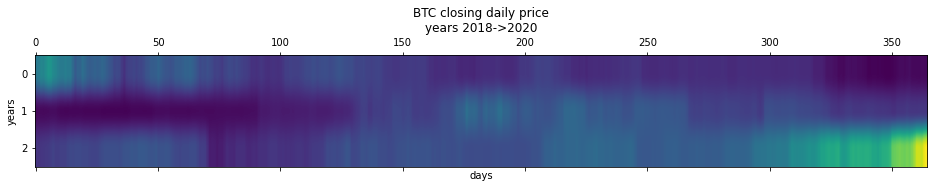

In [42]:
yrs = ['Close', 'Close2019', 'Close2020']

plt.matshow(years[yrs].dropna().T, interpolation=None, aspect='auto')

plt.title('BTC closing daily price\nyears 2018->2020')
plt.ylabel('years')
plt.xlabel('days')
plt.show()

The problem we see in the plot above is that matshow seems to scale the colors relative to the whole 3 years worth of data.  
We've seen in the box plots above that that 2021 has a much higher mean value than all previous years.  

So this upward going trend from one year to the next obscures the evolution of price throughout the year and makes it less visible.  

Therefore I'll first normalize (from min 0 to max 1) the closing price for each year and replot.

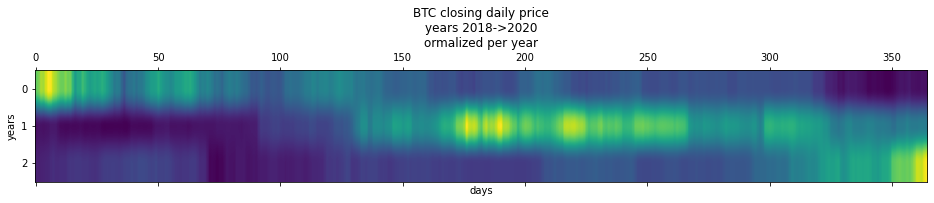

In [43]:
norm_years=(years-years.min())/(years.max()-years.min())

plt.matshow(norm_years[yrs].dropna().T, interpolation=None, aspect='auto')

plt.title('BTC closing daily price\nyears 2018->2020\normalized per year')
plt.ylabel('years')
plt.xlabel('days')

plt.show()

Now it's easier to spot maximum and minimum per year, but we still don't see an pattern across years.

How about a daily pattern ?  

Let's see a heatmap of price during the day for 10 consecutive days.

break


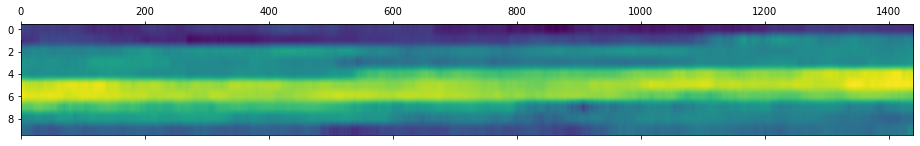

In [44]:
groups = btc_df.groupby(pd.Grouper(freq='D'))

days = pd.DataFrame([])

for i, (name, group) in enumerate(groups):
    tmp = group.Close
    tmp.index = tmp.index.strftime('%H:%M')
    
    days = days.join(tmp, rsuffix=name.year, how = "outer")
    
    if i == 9:
        print('break')
        break
    
plt.matshow(days.T, interpolation=None, aspect='auto')
plt.show()

Still not very informative. This doesn't seem to be the right way to look at assets prices and now we know.

### 6.5 Lag plots  

Time series data implies a relationship between the value at a time t+1 and values and previous points in time.  

The step size we take to go back in time is called **lag** (lag of 1, lag 2 etc).  

Pandas provides the lag plot method. Let's examine the plot first.

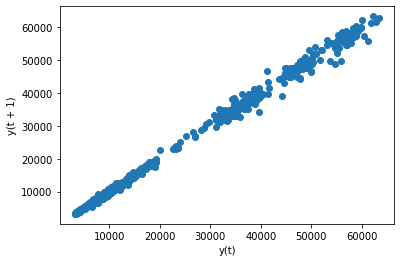

In [45]:
from pandas.plotting import lag_plot

lag_plot(btc_df.groupby(pd.Grouper(freq='D')).Close.mean())

plt.show()

We see a strong positive relation between Close price at t and Close price at t+1.  

Let's experiment with the lag value.

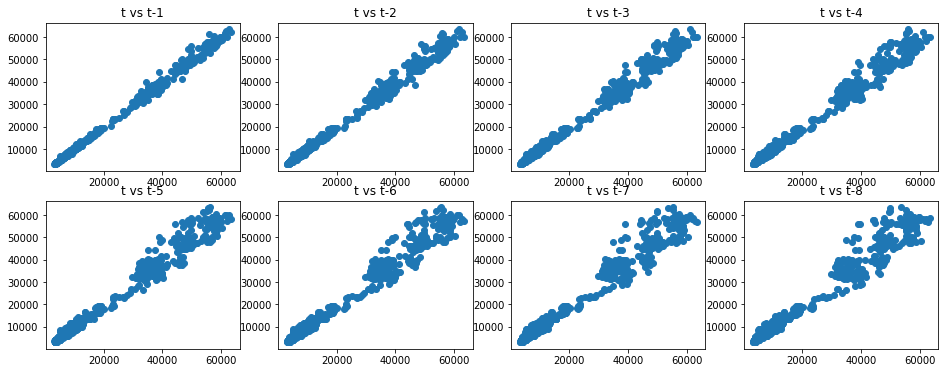

In [46]:
daily_df = btc_df.groupby(pd.Grouper(freq='D')).Close.mean()
daily_values = pd.DataFrame(daily_df.values)

lags = 8
columns = [daily_values]

for i in range(1,(lags + 1)):
    columns.append(daily_values.shift(i)) # downward shift by i positions

dataframe = pd.concat(columns, axis=1)

col_names = ['t'] + ['t-'+str(l) for l in range(1,(lags + 1))]

dataframe.columns = col_names

plt.figure(figsize=(16,6))

for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)

plt.show()

Observations: the price at t correlates quite strongly with the price at previous time points (from t-1 to t-8), for lower price values (approximately half of maximum price). Beyond this value, the correlation becomes weaker the more we go back in time.  

We know from the first line plot we looked at that Bitcoin price surged in 2021. Also, common knowledge of crypto assets market says that prices get very volatile when there is a lot of hype and more people get into the market. So, when prices are high, we expect a lot of volatility (more abrupt and erratic price changes across days). This is what the plots above tell us too.  

So, what we conclude: there's a strong positive relationship with prices on previous days, but not so much when the market becomes hyped and volatile.

### 6.6 Autocorrelation plots

Lag plots showed a relationship between current price and price at previous time points.  

We can also quantify the relationship between the price and the actual lag value.  

For a lag=1, we can compute the correlation between current time step value and previous time step value. If we have n time steps in our data, we'll have n-1 correlation values. These values can be anywhere inthe interval [-1,1].  

-1 (strongest negative correlation)  
0 (no relationshop at all)  
1 (strongest positive correlation)  

This computation can be done for lag=1 to any lag value we want.

Pandas provides the **autocorrelation_plot()** function for this.  

Values outside the dotted lines are statistically significant.  

For many types of time series data this will look like a sinusoid, with a decreasing amplitude. It's not the case for asset prices (at least not for those with large liquidity  - traded by many people).  

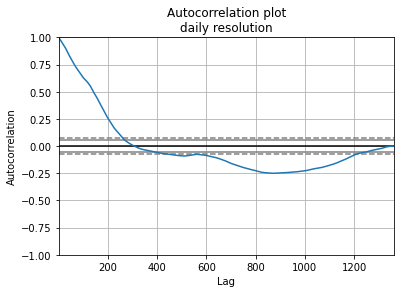

In [47]:
from pandas.plotting import autocorrelation_plot

btc_days_df = btc_df.groupby(pd.Grouper(freq='D')).Close.mean()

autocorrelation_plot(btc_days_df)

plt.title('Autocorrelation plot\ndaily resolution')
plt.show()

We see a statistically significant correlation with up tp 200-ish previous days average prices. The more we go back in time, the lower the correlation, until it starts to become slightly negative (statistically significant).  

We know markets have a global evolution (bull / bear market) and local trends (short term excitement for the price of an asset and then slight corrections).

So, depending on the time resolution our data has, I expect the autocorrelation plot to capture the underlying long or short term trend. 

# 7. Power transforms 

Let's see the linear plot again.

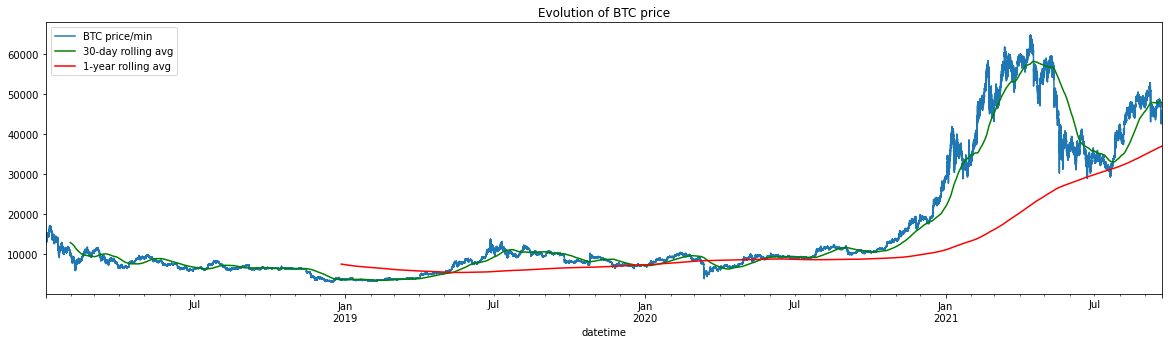

In [48]:
#btc_df.plot(x='datetime', y='Close', figsize=(8,5))

month_sz = 60 * 24 * 30
year_sz = 12 * month_sz

btc_df.Close.plot(figsize=(20,5))

# tail-rolling average transform
rolling_m = btc_df.Close.rolling(window=month_sz)
rolling_m_mean = rolling_m.mean()
rolling_m_mean.plot(color='green')

rolling_y = btc_df.Close.rolling(window=year_sz)
rolling_y_mean = rolling_y.mean()
rolling_y_mean.plot(color='red')

plt.legend(['BTC price/min', '30-day rolling avg', '1-year rolling avg'])
plt.title('Evolution of BTC price')
plt.show()

<a id='non_stationary'></a>
We see that the data is non-stationary: there is an **increasing trend**, yet non-linear (the 1-year rolling average in the plot above, going up at least in the last two years) and a **seasonality** component (local ups and downs).  

Furthermore, data **variance** (difference between peaks and throughs in the local oscillaions) also changes (higher in the last year). 

These make it more difficult to model the data with classical statistical methods.

A common wasy to remove these and to improve the signal to noise ratio are power transforms.  

Two of the commonly used power transforms are: **square root** and **log transform**. 

### Square root

Square root helps bring the data into a linear trend and well-behaved distribution (i.e. Gaussian, uniform) *when* the data is quadratic.  

Here's an example on made up data.

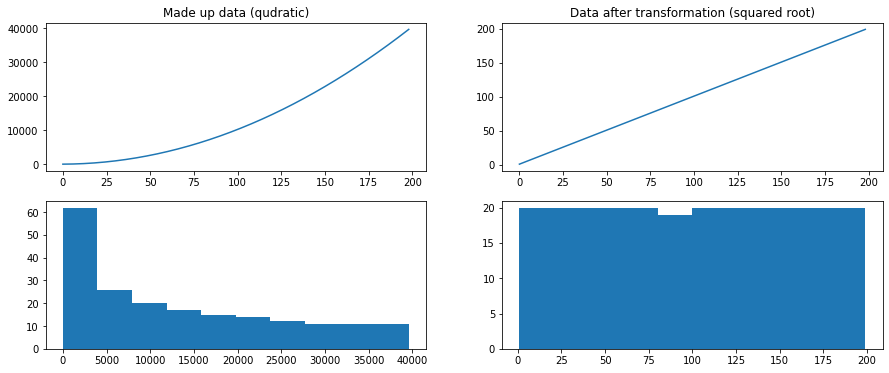

In [49]:
quad_data = [i**2 for i in range(1,200)]
plt.figure(figsize=(15,6))

## quadratic data plots
# line plot
plt.subplot(221)
plt.plot(quad_data)
plt.title('Made up data (qudratic)')

# histogram
plt.subplot(223)
plt.hist(quad_data)

## square root data plots
# linear plots
sq_data = np.sqrt(quad_data)
plt.subplot(222)
plt.plot(sq_data)
plt.title('Data after transformation (squared root)')

# histogram
plt.subplot(224)
plt.hist(sq_data)

plt.show()

Here's the result on our real world data:

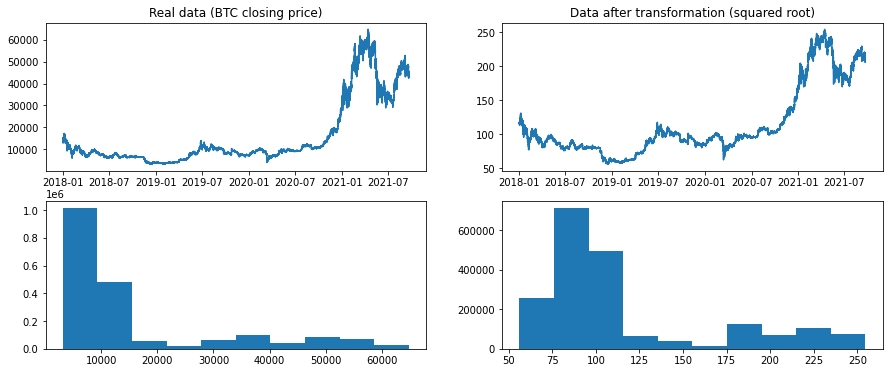

In [50]:
data = btc_df.Close
plt.figure(figsize=(15,6))

## quadratic data plots
# line plot
plt.subplot(221)
plt.plot(data)
plt.title('Real data (BTC closing price)')

# histogram
plt.subplot(223)
plt.hist(data)

## square root data plots
# linear plots
sq_data = np.sqrt(data)
plt.subplot(222)
plt.plot(sq_data)
plt.title('Data after transformation (squared root)')

# histogram
plt.subplot(224)
plt.hist(sq_data)

plt.show()

The squared root doesn't seem to help because our data is not quadratic.

### Log transform

Log transforms help when the data has an exponential trend, which is often likened to a hokey stick in asset price popular terminology.  

We could say we see something like a hockey stick starting in Jan 2021. Let's explore this.

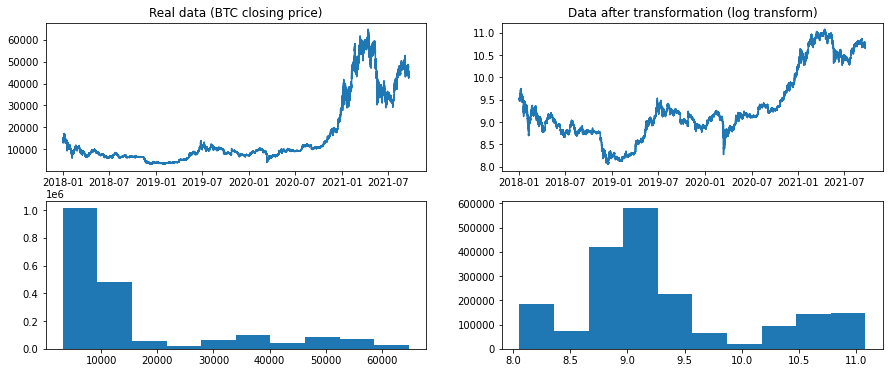

In [51]:
data = btc_df.Close
plt.figure(figsize=(15,6))

## initial data plots
# line plot
plt.subplot(221)
plt.plot(data)
plt.title('Real data (BTC closing price)')

# histogram
plt.subplot(223)
plt.hist(data)

## square root data plots
# linear plots
sq_data = np.log(data)
plt.subplot(222)
plt.plot(sq_data)
plt.title('Data after transformation (log transform)')

# histogram
plt.subplot(224)
plt.hist(sq_data)

plt.show()

It doesn't look like the right power transformation for our data.

### Automatic search for the right power transform

scipy package offers a method to automatically search for the most suitable power transformation for a dataset: <a href='https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html'>boxcox function</a>.

[Short overview]  
BoxCox procedure identifies the appropriate exponent (lambda = l) to use to transform data into a well-behaved distribution.    

The returned lambda value indicates the power to which all data should be raised.  

In order to do this, the Box-Cox power transformation searches from lambda = -5 to lambda = +5 until the best value is found.  

Best lambda means: the one for which the transformed data's standard deviation is the smallest. In this situation, the data has the highest likelihood – but not a guarantee – to be normally distributed.

Table 1: Common Box-Cox Transformations

| lambda | transformed Y |   
| --- | --- |   
| -2 | 	Y^(-2) = 1/Y^2
| -1 | 	Y^(-1) = 1/Y^1
| -0.5 | 	Y^(-0.5) = 1/(Sqrt(Y))
| | 	log(Y)
| 0.5 | 	Y^(0.5) = Sqrt(Y)
| 1 | 	Y^1 = Y
| 2 | 	Y^2

best lambda: -0.5154025041386202


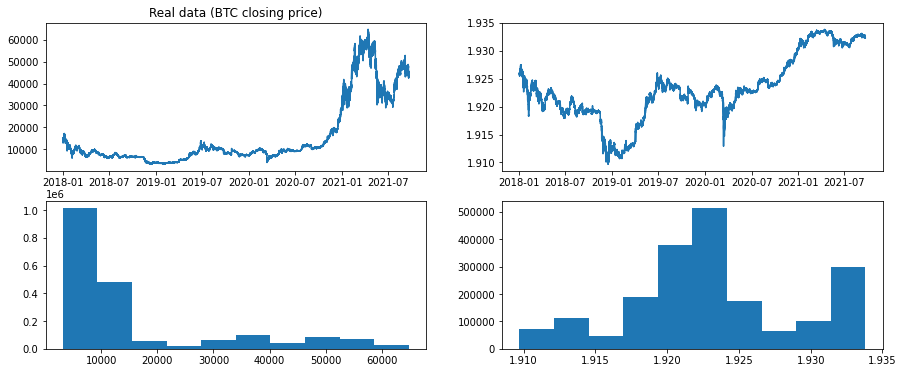

In [52]:
# automatically box-cox transform a time series
from scipy.stats import boxcox

plt.figure(figsize=(15,6))

## initial data plots
# line plot
plt.subplot(221)
plt.plot(data)
plt.title('Real data (BTC closing price)')

# histogram
plt.subplot(223)
plt.hist(data)

## transformed data plots
temp_df = pd.DataFrame(btc_df.Close)
temp_df.columns = ['Close']

temp_df['Close'], lambda_val = boxcox(temp_df['Close'])
print(f'best lambda: {lambda_val}')

# line plot
plt.subplot(222)
plt.plot(temp_df['Close'])

# histogram
plt.subplot(224)
plt.hist(temp_df['Close'])
plt.show()

The best power transformation for our data seems to be the reciprocal square root (lambda = -0.5), according to the boxcox method.  

The distribution we obtain is the closest to a normal distribution, so far. But the trend is not linear. We see what happens with data from previous bull markets (2018 highs become more pronounced after this transformation). Too bad we don't have data from December 2017, when the actual peak of the previous bull market happened for BTC prices. My guess is it would approach the level of July 2021 in a transformed plot.  

I won't explore this further for the moment, as I'm not convinced this is the right transformation we need for our data.

# 8. Temporal structure of time series data

## 8.1 White noise

In a [previous section](#log_returns) I computed the log returns for the BTC close price. This plot reminded me of white noise.  

We can formally investigate if it actually is white noise .  

A time series is white noise if the variables are independent and identically distributed with a mean of zero.  

White noise is important in time series forecasting for two reasons:  
1. **Prediction**: If a time series is white noise, then it's by definition random and cannot be predicted.
2. **Diagnosis**: The errors of a time series model should be white noise. What does this mean ? That the erros contain no information, as all the information from the time series was harnessed by the model itself. And the opposite ? If the erors are not white noise, the model can be improved further.

However, it's generally expected that any real like time series will contains a certain amount of white noise.

A series is *not* white noise if:
- the mean is non zero
- the variance changes over time
- the is a significant autocorrelation (with lagged values)

In [53]:
lret_btc = log_returns(btc_df.Close,1)[1:]

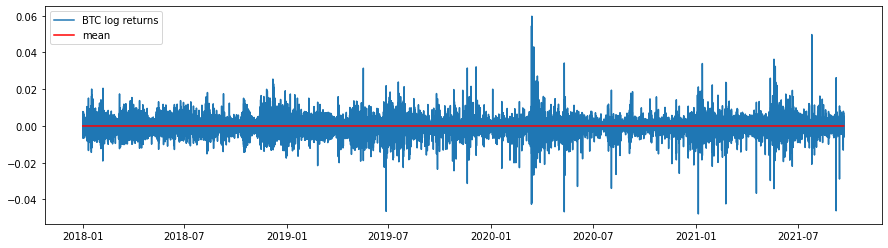

In [54]:
f = plt.figure(figsize = (15,4))

plt.plot(lret_btc)
plt.plot(lret_btc.index, [lret_btc.mean()] * len(lret_btc), color='red')
plt.legend(['BTC log returns', 'mean'])

plt.show()

In [55]:
print(lret_btc.describe())

count    1.956959e+06
mean     5.789393e-07
std      1.221378e-03
min     -4.789219e-02
25%     -3.609924e-04
50%      1.820329e-06
75%      3.653205e-04
max      5.974073e-02
Name: Close, dtype: float64


Mean and std are almost 0. Since variance = std^2, it's also close to 0. 

Since we have a lot of data, we can split it into shorter time intervals and see if the summary stats change. 

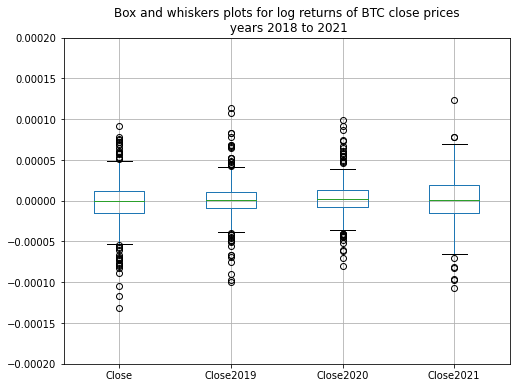

In [56]:
groups = lret_btc.groupby(pd.Grouper(freq='A')) # group by year

years = pd.DataFrame([])

for name, group in groups: # iterate through the years
    tmp = group.groupby(pd.Grouper(freq='D')).mean() # compute the daily mean
    tmp.index = tmp.index.strftime('%m-%d') # transform the index into 'mm-dd' only
    
    years = years.join(tmp, rsuffix=name.year, how = "outer") # join together yearly series (on the 'mm-dd' index) 
    
years.boxplot(figsize=(8,6))
plt.ylim([-0.0002, 0.0002])
plt.title('Box and whiskers plots for log returns of BTC close prices\n years 2018 to 2021');

Let's see the autocorrelation for the log returns now.

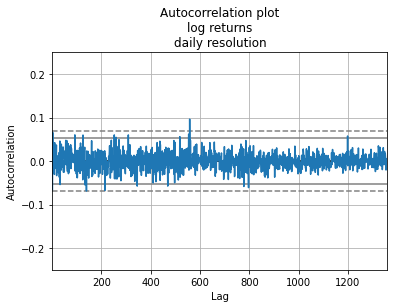

In [57]:
lret_btc = log_returns(btc_df,1)[1:]

temp_df = lret_btc.groupby(pd.Grouper(freq='D')).Close.mean()

autocorrelation_plot(temp_df)

plt.title('Autocorrelation plot\nlog returns\ndaily resolution')
plt.ylim([-0.25, 0.25])
plt.show()

The spikes past the 95% (solid grey line) and 99% (dotted grey line) confidence levels look like a statistical fluke, in this context.  

I conclude that log returns are white noise and cannot be predicted.

## 8.2 Random walk  

First, let's see a perfect random walk dataset and then we'll look at our own data again.  

A time series is constructed through a *random walk* process as follows:  
y(t) = X(t-1) + rnd_step,  
where rnd_step is randomly selected from {-1, 1} and os is x(0).  

We construct this dataset below.

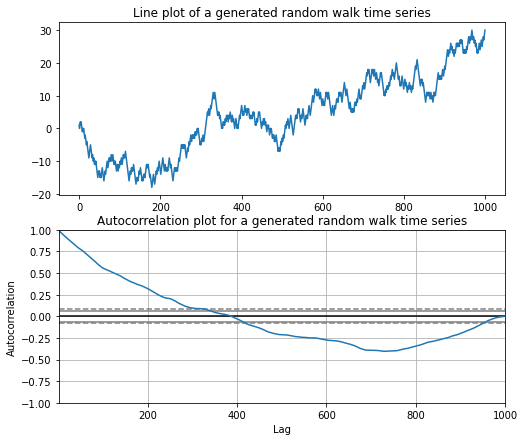

In [58]:
from random import seed
from random import random

seed(101)

values = [-1 if random() < 0.5 else 1] # x(0)

for i in range(1, 1000):
    rnd_step = -1 if random() < 0.5 else 1
    y_t = values[i-1] + rnd_step
    values.append(y_t)

plt.figure(figsize=(8,7))

# linear plot
plt.subplot(211)    
plt.plot(values)
plt.title('Line plot of a generated random walk time series')

# correlogram
plt.subplot(212)    
autocorrelation_plot(values)
plt.title('Autocorrelation plot for a generated random walk time series')

plt.show()

In section [section 6.6](#6.6-Autocorrelation-plots) I plotted the autocorrelation for BTC close price. Let's see it again.

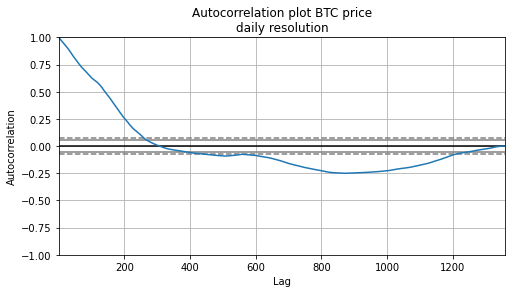

In [59]:
from pandas.plotting import autocorrelation_plot

btc_days_df = btc_df.groupby(pd.Grouper(freq='D')).Close.mean()

plt.figure(figsize=(8,4))
autocorrelation_plot(btc_days_df)

plt.title('Autocorrelation plot BTC price\ndaily resolution')
plt.show()

The autocorrelation plot of the closing price looks exactly like that of a random walk. Random walks are tricky to predict. Still, most assets price data looks like a random walk, from what I read.  

In [section 7](#non_stationary) I mentioned our closing price time series looking **non-stationary**. It's time to apply formal methods to test this assumption.  

The *statsmodel* library provides the *adfuller()* method which implements the *Augmented Dickey-Fuller test*.  

In [60]:
# calculate the stationarity of our closing price data
from statsmodels.tsa.stattools import adfuller

# statistical test
result = adfuller(btc_days_df)

print(f'ADF result: {result[0]} p={result[1]:.3f}') 

print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value:.3f}')

ADF result: -0.5461669071950356 p=0.883
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Null hypothesis (H0) of the ADF test: time series is non-stationary.  
Based on the results, H0 cannot be rejected and the chances of this being a fluke are small.  

Then the next interesting question is **how we can make it stationary**.  

An easy method is to **subtract the previous value** for each time step t. That would be an obvious thing to do since we know our dataset looks like a random walk and we know that we obtained a random walk by using a linear function of Close(t-1) to predict Close(t).

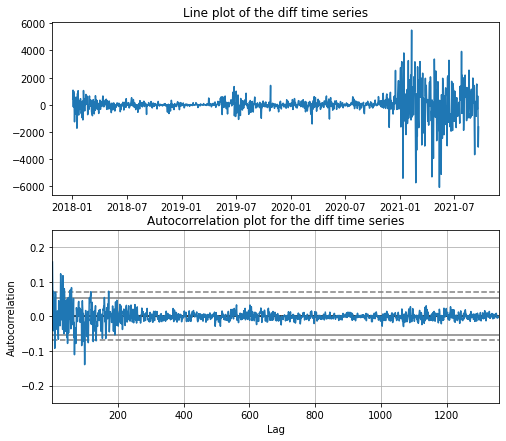

In [61]:
diff_df = btc_days_df.diff()[1:]

plt.figure(figsize=(8,7))

# linear plot
plt.subplot(211)    
plt.plot(diff_df)
plt.title('Line plot of the diff time series')

# correlogram
plt.subplot(212)    
autocorrelation_plot(diff_df)
plt.title('Autocorrelation plot for the diff time series')
plt.ylim([-0.25, 0.25])
plt.show()

<a id='persistence_model'></a>
Sadly, it looks like we get white noise when we remove non-stationarity, which we know contains no structure that we can model and use for prediction.  

A naive model for white noise is:  
*Close(t) = Close(t-1)*  
This is also called the **persistence model**  
Just because we know the next value is a function of the current value but we have no way to build a model of this relationship.  

The persistence model will be the baseline for any future model.

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# prepare dataset
train_size = int(len(btc_days_df) * 0.5)
train, test = btc_days_df[0:train_size], btc_days_df[train_size:]

# persistence
preds = []
prev = train[-1]

for i in range(len(test)):
    preds.append(prev)
    prev = test[i]
    
rmse = sqrt(mean_squared_error(test, preds))
print(f'Persistence model RMSE: {rmse:.3f}')

Persistence model RMSE: 1045.388


In conclusion, I found out that this data is likely a random walk time series. I think that discovering this through analysis is more valuable than having read this commonly known fact directly from some article dealing with forecasting security prices over time. 

## 8.3 Time series decomposition  

A time series is conceptualized as having these types of components:
1. **systematic components**
    - **level** = overall average value 
    - **trend** = temporary upward or downward movement 
    - **seasonality** = a short-term cycle that repeats itself   
2. **non-systematic components**
    - **random noise**
    
The 4 components are thought to combine in two possible ways into a time series:  
- additive  
    *Close(t) = level + trend + seasonality + noise*  
        
- multiplicative  
    *Close(t) = level * trend * seasonality * noise*  
    
In reality, time series data can have:
- both additive and multiplicative components  
- both upward and downward trends (especially security price data)  
- non-repeating and repeating cycles

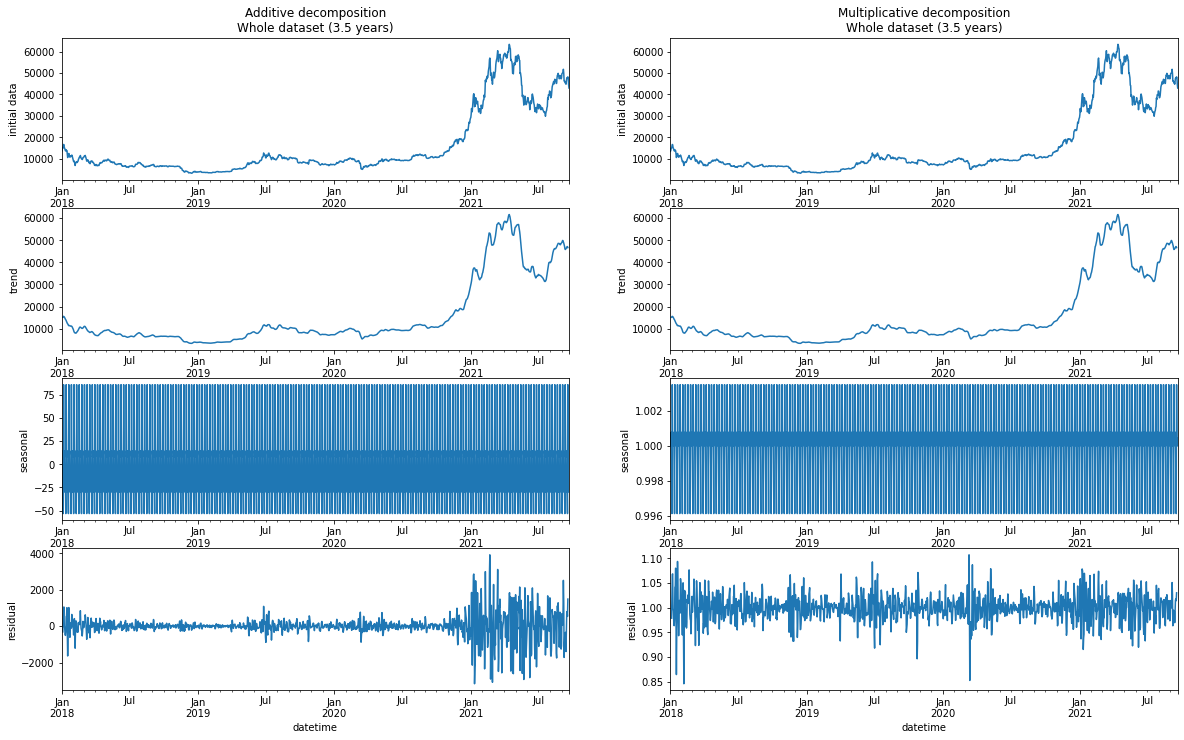

In [63]:
from statsmodels.tsa.seasonal import seasonal_decompose

##whole data
data = btc_days_df
decomp = seasonal_decompose(data, model='additive')

plt.figure(figsize=(20,12))

plt.subplot(421)
data.plot()
plt.ylabel('initial data')
plt.title('Additive decomposition\nWhole dataset (3.5 years)')

plt.subplot(423)
decomp.trend.plot()
plt.ylabel('trend')

plt.subplot(425)
decomp.seasonal.plot()
plt.ylabel('seasonal')

plt.subplot(427)
decomp.resid.plot()
plt.ylabel('residual')

##small window
data = btc_days_df
decomp = seasonal_decompose(data, model='multiplicative')

plt.subplot(422)
data.plot()
plt.ylabel('initial data')
plt.title('Multiplicative decomposition\nWhole dataset (3.5 years)')

plt.subplot(424)
decomp.trend.plot()
plt.ylabel('trend')

plt.subplot(426)
decomp.seasonal.plot()
plt.ylabel('seasonal')

plt.subplot(428)
decomp.resid.plot()
plt.ylabel('residual')

plt.show()

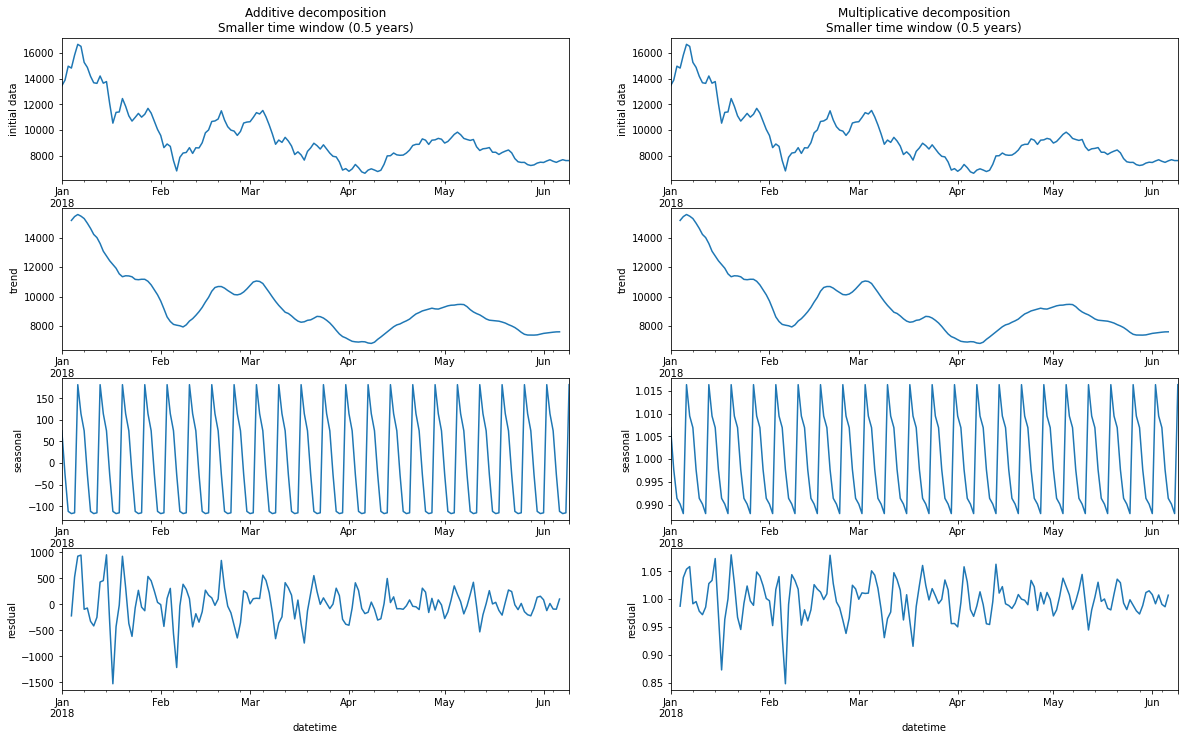

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

##whole data
data = btc_days_df[:160]
decomp = seasonal_decompose(data, model='additive')

plt.figure(figsize=(20,12))

plt.subplot(421)
data.plot()
plt.ylabel('initial data')
plt.title('Additive decomposition\nSmaller time window (0.5 years)')

plt.subplot(423)
decomp.trend.plot()
plt.ylabel('trend')

plt.subplot(425)
decomp.seasonal.plot()
plt.ylabel('seasonal')

plt.subplot(427)
decomp.resid.plot()
plt.ylabel('resdual')

##small window
data = btc_days_df[:160]
decomp = seasonal_decompose(data, model='multiplicative')

plt.subplot(422)
data.plot()
plt.ylabel('initial data')
plt.title('Multiplicative decomposition\nSmaller time window (0.5 years)')

plt.subplot(424)
decomp.trend.plot()
plt.ylabel('trend')

plt.subplot(426)
decomp.seasonal.plot()
plt.ylabel('seasonal')

plt.subplot(428)
decomp.resid.plot()
plt.ylabel('resdual')

plt.show()

What I would like to find out is how to get more insight from these plots.  

For example:  
- I see that additive and multiplicative decomposition produced similar plot. How to judge which one is better ?  
- The seasonal components look similar, but the multiplicate is centered around 1 while the additive seems to have an average somewhere between 0 and 50  
- The average residuals have a mean of 0 while the multiplicative have a mean of 1
- Also, the amplitude of residuals is quite different, orders of magnitude different (4000 versus 1) My naive interpretation is that the additive model does not capture the information in the data well enough and it's even more wrong in periods of hype (start of 2018 and 2021).

Unfortunately, all articles, blog posts and book chapters I found so far stop at showing these plots and briefly mentioning what trend, season and remainders mean. As I find out more about what conclusions we can draw, I will update this notebook.

## 8.4 Removing trends  

To clarify, a trend is a *systematic change* that does not seem to be periodic. In our case, a bull market or a bear market have upward / downward trends.  

Why we'd want to look into the trend of the dataset:  
- can inform **which modelling algorithm** we can use
- we could **remove** the identified trend and simplify prediction (remove information)
- trend information can become an **extra feature** for training (add information)

We can group trends into two large groups:
- deterministic - they are consistent(e.g. temperatures across years)
- stochastic - they tend to swtich between up and down  

We can also call them:  
- global trends
- local trends (I guess the bear and the bull market would fit into a local trend)

Time-series that contain a trend are labelled **non-stationary**. We can *detrend* the data and make it stationary.  

The interesting thing is that detrending "is common when using statistical methods for time series forecasting, but does not always improve results when using machine learning models." (<a href='https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/'>Introduction to Time Series Forecasting With Python</a> by Jason Brownlee).  
Something to keep in mind.

There are two main ways to detrend:  
- differencing
- model the trend 

In [section 8.2](#detrend_differencing) we applied differencing to remove the trend when we assumed our data is a random walk. We were left with something that looked like white noise, which cannot be modelled.  

Let's try to model the trend using a >1 degree **polynomial function**, since we know from just looking at it that our trend is not linear.  

I will assume it's a cubic (3rd degree) polynomial:  
y = a * x + b * x^2 + c * x^3 + d

Quick overview of what polynomials look like:
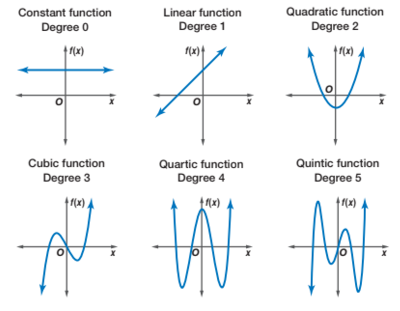

Source: <a href='https://en.wikiversity.org/wiki/Algebra_II/Polynomial_Functions'>Wikiversity</a>

If you have to revisit curve fitting procedure (like I had to do), <a href='https://machinelearningmastery.com/curve-fitting-with-python/'>this tutorial is great</a>.  

A summary from the tutorial mentioned above:   
"*Curve fitting involves first defining the functional form of the mapping function (also called the basis function or objective function), then searching for the parameters to the function that result in the minimum error." (<a href='https://machinelearningmastery.com/curve-fitting-with-python/'>Curve Fitting With Python</a>, by Jason Brownlee)*

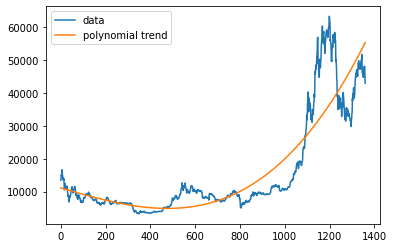

In [65]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

data = btc_days_df

# create our independent variable; our X values are the timesteps, 
# but we can make it just as well an array from 0 to ..., since the 
# actual value does not matter
X = [i for i in range(0, len(data))]
X = np.reshape(X, (len(X), -1))

y = data.values # dependent variable is the closing price

pf = PolynomialFeatures(degree=3) # a cubic polynomial model
Xp = pf.fit_transform(X)          # transform X into a quadratic form (each row i will be: x[i]^0 x[i]^1 x[i]^2 x[i]^3) 

# fit the quadratic model through ordinary least squares Linear Regression
md2 = LinearRegression() 
md2.fit(Xp, y)

trendp = md2.predict(Xp)

plt.plot(X, y)
plt.plot(X, trendp)
plt.legend(['data', 'polynomial trend'])
plt.show()

Looks like a close fit.  

Let's see the detrended data.

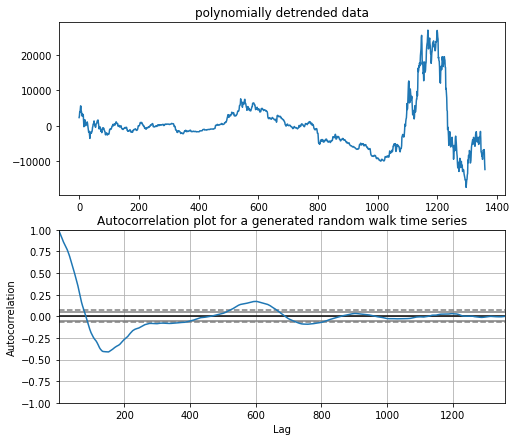

In [66]:
plt.figure(figsize=(8,7))

detrpoly = [y[i] - trendp[i] for i in range(0, len(y))]

plt.subplot(211)    
plt.plot(X, detrpoly)
plt.title('polynomially detrended data')

# correlogram
plt.subplot(212)    
autocorrelation_plot(detrpoly)
plt.title('Autocorrelation plot for a generated random walk time series')

plt.show()

Detrended data doesn't seem to have a trend we can spot with the naked-eye. Let's see the prediction error.

In [67]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y, trendp)
rmse = np.sqrt(mean_squared_error(y, trendp))
print('r2:', r2)
print('rmse', rmse)

r2: 0.7904972202122598
rmse 6924.059986425642


Remember the [persistence model](#persistence_model) from earlier ? It had better RMSE (1045). But of course we don't expect the trend to be a good prediction model for this problem. We just model it so we can remove it from the data and then find a good model on the detrended data. 

## 8.5 Removing seasonality   

*Seasonality* is a short-term pattern that repeats itself at a fixed frequency. A one-time cycle is just that, a cycle, not seasonality. 

Its effect:  
- may obscure the pattern in our data (and we remove it)
- can be picked up by our modelling algorithm (we can use it as extra feature)  
Both are valid approaches.  

There are many method to deseasonalize a dataset. Not all can be used in forecasting problems. Some can only be used in analysis of past data. Something to keep in mind for other type of problems.  

Just as with detrending, we can do:  
- differencing  
- modelling  

**Differencing**

In [section 8.3](#8.3-Time-series-decomposition) we saw something that looked like weekly seasonality (easy to spot in the shorter time window plot there).  

So I'll subtract from each day the closing price of the day 1 week before.

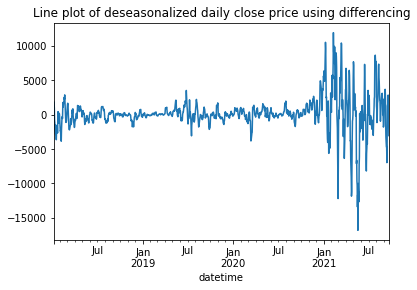

In [68]:
tmp = btc_days_df

lag_df = pd.concat([tmp.shift(7, axis = 0), tmp], axis=1)[7:] # remove the first 7 non differenced rows

lag_df.columns = ['t', 't+7']

diff_data = lag_df['t+7'] - lag_df['t']

diff_data.plot()
plt.title('Line plot of deseasonalized daily close price using differencing')

plt.show()

**Modelling seasonality**

Like with detrending, we can model the seasonality and subtract it from the data.  

Seasonality has the shape of the sine, which can be modelled as a 4th degree polynomial:  
y = a * x + b * x^2 + c * x^3 + d * x^4 + e

<function matplotlib.pyplot.show(close=None, block=None)>

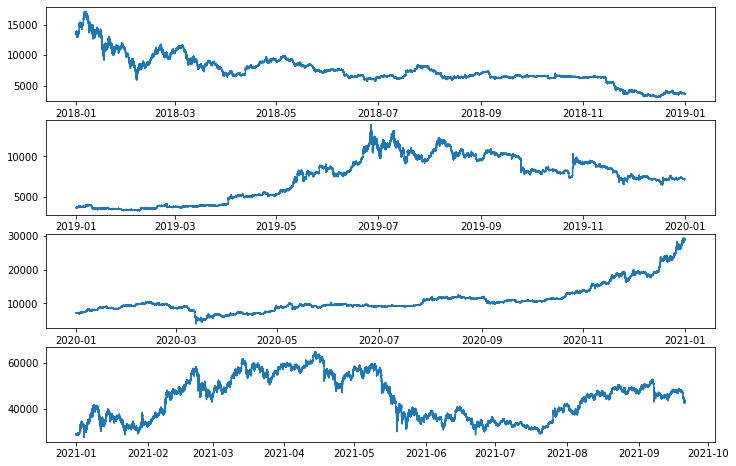

In [69]:
groups = btc_df.groupby(pd.Grouper(freq='A'))

count = len(groups)

plt.figure(figsize=(12,8))

for i, (name, group) in enumerate(groups):
    plt.subplot(count*100 + 10 + i+1)
    plt.plot(group.index.values, group.Close.values)
plt.show

It's hard to see if there's a seasonal componentt, constistent across all years.

Using the daily closing price, I'm going to do the following:
- break the dataset into four years
- try to fit seasonality models (4th degree polynomials) of 3 different frequencies: weekly, monthly, trimestrial

<function matplotlib.pyplot.show(close=None, block=None)>

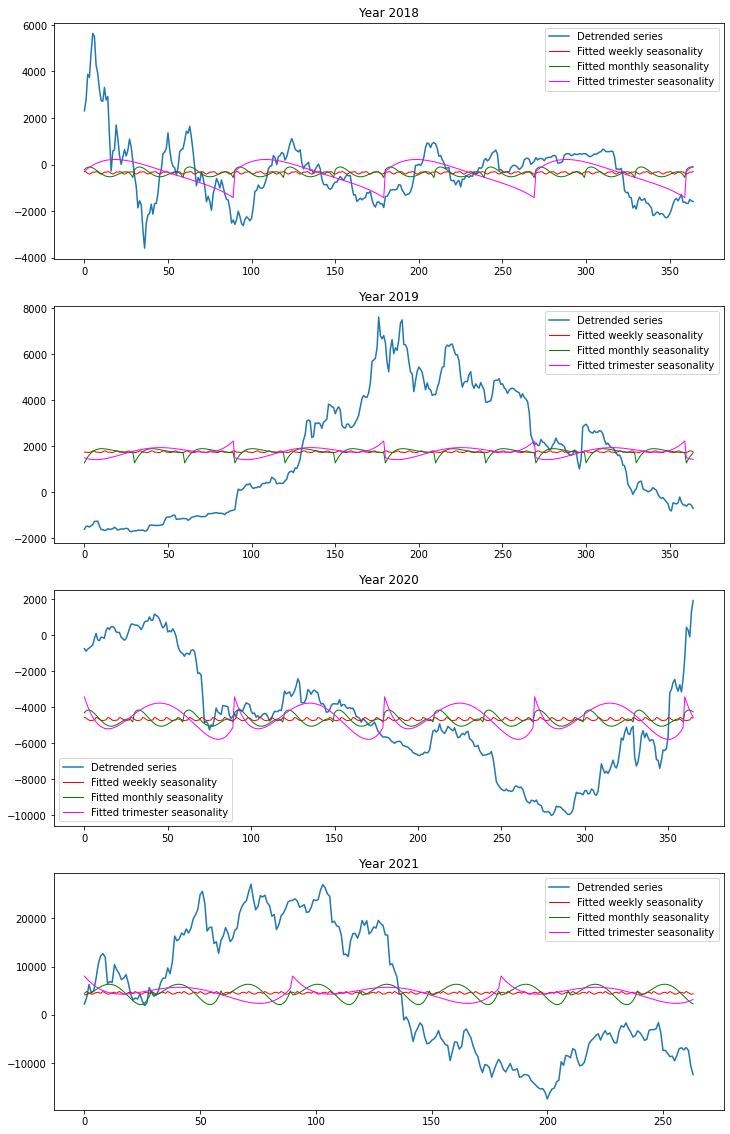

In [70]:
groups = btc_days_df.groupby(pd.Grouper(freq='A'))
days_per_year = []
for name, group in groups:
    days_per_year.append(len(group.values))

plt.figure(figsize=(12,20))

start = 0
years = [2018, 2019, 2020, 2021]
count = len(days_per_year)

legend = ['Detrended series', 'Fitted weekly seasonality', 'Fitted monthly seasonality', 'Fitted trimester seasonality']

for i, days in enumerate(days_per_year):
    series = detrpoly[start:start+days]
    
    plt.subplot(count*100 + 10 + i+1)
    plt.title(f'Year {years[i]}')
    
    plt.plot(series)
    
    intervals = [7, 30, 90]
    cols = ['red', 'green', 'magenta']

    for cnt, inter in enumerate(intervals):
        X = [i%inter for i in range(0, len(series))] # let's try to model a weekly seasonality as a sinusoid
        y = series

        degree = 4

        coef = np.polyfit(X, y, degree)

        # create curve
        curve = list()
        for i in range(len(X)):
            value = coef[-1]
            for d in range(degree):
                value += X[i]**(degree-d) * coef[d]
            curve.append(value)
        
        # plot curve over original data
        plt.plot(curve, color=cols[cnt], linewidth=1)
        plt.legend(legend)
    start = start+days
plt.show

This doesn't look like anything to me. The seasonality amplitude is so small, I don't think it matters if we remove it or not or if we add it as an egineered feature.

## 9. Model evaluation

In ML uspervised learning problems we usually use a train-test split to separate our dataset into data to use for training and data to use for testing.  

How do we do this with time series data, where we can't just do a random split, since we have to respect the order of the data ?

Apparently, there are three common method to split data for backtesting:
1. Train-test split respecting the temporal order  
2. Multiple train-test split respecting the temporal order  
3. Walk-forward validation, where we update the model every time we reveice a new piece of data


1. Train-test split respecting the temporal order

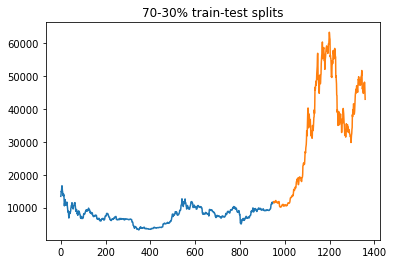

In [71]:
X = btc_days_df.values

train_size = int(len(X) * 0.7)
train, test = X[0:train_size], X[train_size:len(X)]

plt.plot(train)
plt.plot([None for i in train] + [x for x in test])

plt.title('70-30% train-test splits')
plt.show()

I don't think training on 2018-2020 data and predicting on 2021 data is a good idea ^^

2. Multiple train-test split respecting the temporal order

sklearn provides the TimeSeriesSplit method.  

We decide on the number of splits first. Let's say we want 3 splits. TimeSeriesSplit will divide the data into 4 batches of equal size, respecting the temporal order. And the 4 batches are used for training different models in this way:

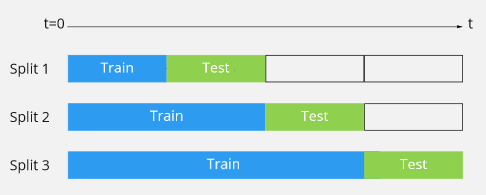

The size of the test set is contastant, while the size of the training set keep increasing.

Still doesn't solve the problem I noticed with the previous train-test split method.  

Furthermore, in practice, time series models are retrained as new data comes in. 

3. Walk-forward validation

Again, temporal order is respected. This is always the case with time series data.  

- We start on small window of our dataset (we can chose a minimum window width to our liking). We train on this window and predict the value for the next time stamp.
- We expand the window with the new observation, retrain, predict for the next point in time  
- and so on...  

We can opt for an expanding window or for a sliding window (which slides 'to the left' instead of increasing in size).  
With this method, for 2 mil data points (our initial data size for BTC, at 1-min resolution), we'll end up training about 2 mil models. I don't know if it's feasible or we'd have to do some window jumps instead of sliding. Also, in this case, an expanding window might be computationally expensive (training of 1 mil data points), I don't know yet.  

In any case, this seems to be the way to do training in time series modeling.

**Evaluating the persistence model**

The persistence model was the naive one that predicts for the next time step the same value from the current time step. This seems like a good baselin model for security price, since the linear plot for asset price looked like a random walk anyway. And in random walk remember we  computed the next value as a linear transformation of the current value.  

I'll go through formally evaluating the persistene model more like a practice for the serious models I will eventually build.  

1. Transform the Closing price dataset into a supervised learning problem
2. Establish the train and test sets
3. Define the persistence model
4. Make predictions and establish a baseline performance

In [72]:
data = btc_days_df

df = pd.concat([data.shift(1), data], axis=1)
df.columns = ['t', 't+1']

print(dataframe.head(5))

              t           t-1           t-2           t-3           t-4  t-5  \
0  13440.450886           NaN           NaN           NaN           NaN  NaN   
1  13885.451885  13440.450886           NaN           NaN           NaN  NaN   
2  14968.705857  13885.451885  13440.450886           NaN           NaN  NaN   
3  14820.753062  14968.705857  13885.451885  13440.450886           NaN  NaN   
4  15828.013939  14820.753062  14968.705857  13885.451885  13440.450886  NaN   

   t-6  t-7  t-8  
0  NaN  NaN  NaN  
1  NaN  NaN  NaN  
2  NaN  NaN  NaN  
3  NaN  NaN  NaN  
4  NaN  NaN  NaN  


I'll do one 70-30% split

In [73]:
X = df.values

train_size = int(len(X) * 0.7)

train, test = X[1:train_size], X[train_size:]

X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

The naive persistence prediction model: receives the current value as input and predicts the same as output.

In [74]:
def pers_predict(x):
    return x

Evaluate using root mean squared error:  
- because squaring errors punishes more the large errors  
- taking the square root brings it back into the same units of measurement

In [75]:
preds = []

for x in X_test:
    yhat = pers_predict(x)
    preds.append(yhat)

rmse = sqrt(mean_squared_error(y_test, preds))

print(f'RMSE: {rmse:.3f}')

RMSE: 1334.401


We've kind of seen this before, in section 8.2, but now I have the whole procedure more formalized.  

There's no point to plot the predictions, since it will overlap on our data (shifting by one time step is not visible when we have 1300 datapoints in a small plot).

**Visualize residuals**

Beyond predicting and evaluating the error, we should look at the errors of each prediction. Here's why:  
- the errors should have a mean at 0. If not, it means our model is biased (tends to err more on the positive or more on the negative side). If we have a biased model, we should know. The most naive way to correct for this is to subtract the mean of residuals from all future predictions.  
- errors should be random (no pattern, no structure). Otherwise, it means the errors contain information. Information that should have been captured by our model. So we need to improve the model.  

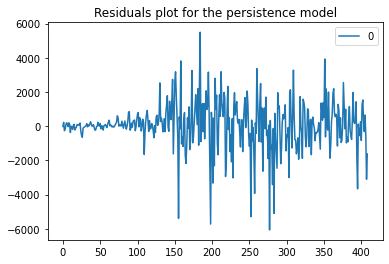

In [76]:
# calculate residuals
residuals = [y_test[i]-preds[i] for i in range(len(preds))]
residuals = pd.DataFrame(residuals)

residuals.plot()
plt.title('Residuals plot for the persistence model')
plt.show()

Examine the summary statistics of the residuals. The means is the most important.

In [77]:
# summary statistics
print(residuals.describe())

                 0
count   409.000000
mean     76.589036
std    1333.832682
min   -6065.863346
25%    -365.700573
50%      85.100873
75%     655.571574
max    5496.937655


The mean is not 0. The persistence model tends to predict higher values than the real ones. This means we should correct for this bias. Solutions range from subtracting 76 (the mean of residuals) for predictions to complex bias correction methods.

**Residuals distribution**

The distribution should be Gaussian, otherwise it means there's something worng with our model.  

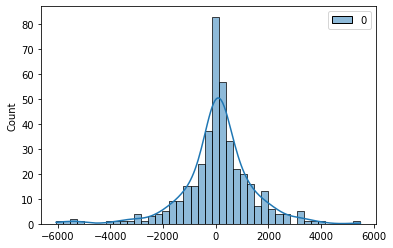

In [78]:
import seaborn as sns

sns.histplot(data = residuals, kde=True)

plt.show()

Difficult to tell with the naked eye. There's something called Q-Q plot that can help.  
- it orders residuals ascendingly
- plots them in a scatterplot against those of an ideal Gaussian distribution

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



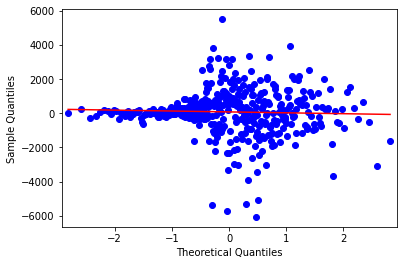

In [79]:
from statsmodels.graphics.gofplots import qqplot

res_arr = np.array(residuals)
qqplot(res_arr, line='r')
plt.show()

<a href='https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot'>This</a> is a usefull discussion on how to interpret the Q-Q plot. It seems like the residuals distribution is a heavy-tail, not a normal one. For an actual prediction model, this would be something to look into and correct.

**Autocorrelation plot of residuals**

We should find no autocorrelation. If there is some, we should improve our model and capture it.  

And the plot below shows no significant autocorrelation.

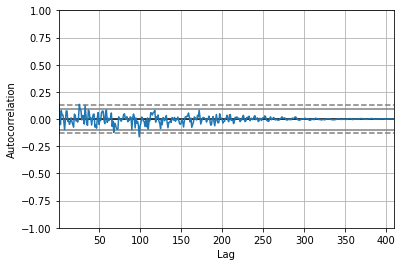

In [80]:
autocorrelation_plot(residuals)
plt.show()

You've reached the temporary end. This is work in progress. There is no conclusion yet. I continue to update this notebook as I read more.